In [1]:
import os
import PIL
import math
import cv2
import squarify
import random
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Data modeling
import tensorflow as tf
from keras import Sequential
from sklearn.model_selection import cross_val_score
from tensorflow import keras as keras
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.layers import Layer, Input, Dense, Dropout, Conv2D, BatchNormalization, Flatten, Input, Conv2D, GaussianNoise, MaxPooling2D, Flatten, Dense, Dropout

#### DATASET ANALYSIS


In [4]:
def load_dataset(path):

    labels = []
    images = []

    for folder in os.listdir(path):
        for lr in os.listdir(path+'/'+folder):  # left or right
            for image in os.listdir(path+'/'+folder+'/'+lr):
                if image.endswith('b') is False:
                    images.append(path+'/'+folder+'/'+lr+'/'+image)
                    labels.append(folder+'-'+lr)  # +'-'+lr

    df = pd.DataFrame(list(zip(labels, images)),
                      columns=['Label', 'ImagePath'])
    return df, labels, images

In [5]:
df, labels, images = load_dataset('../data/CASIA')

# EDA


In [29]:
def missing_values(df):
    missing_count = df.isnull().sum()
    missing_percetanges = pd.DataFrame({
        'Column': missing_count.index,
        'Counts': missing_count.values,
        'Percentage': (missing_count.values / len(df)) * 100
    })
    return missing_percetanges

In [30]:
def explore_data(df):
    head = pd.DataFrame(df.head())
    tail = pd.DataFrame(df.tail())
    nunique = pd.DataFrame(df.nunique(), columns=["#_of_Unique"])
    describe = pd.DataFrame(df.describe())
    dtypes = pd.DataFrame(df.dtypes, columns=["Datatype"])
    labels_distribution = pd.DataFrame(df['Label'].value_counts())
    results = {
        'Table 2: Dataset Head:': head,
        'Table 3: Dataset Tail:': tail,
        'Table 4: Dataset Numerical Describtion: ': describe,
        'Table 5: Missing Values By Percentage': missing_values(df),
        'Table 6: Dataset Columns Data types: ': dtypes,
        'Table 7: Number of uniques in the datasets:': nunique,
        'Table 8: Labels Distribution:': labels_distribution}
    return results

In [31]:
def print_dataset_exploration(results):

    for operation, dataframe in results.items():
        print(f"{operation}")
        if operation == 'Table 6: Missing Values By Percentage':
            print("Total Sum of Missing Percetange: ",
                  dataframe['Percentage'].sum())
        display(dataframe)

In [32]:
print_dataset_exploration(explore_data(df))

Table 2: Dataset Head:


Label                         ImagePath
0  000-L  ../data/CASIA/000/L/S5000L00.jpg
1  000-L  ../data/CASIA/000/L/S5000L01.jpg
2  000-L  ../data/CASIA/000/L/S5000L02.jpg
3  000-L  ../data/CASIA/000/L/S5000L03.jpg
4  000-L  ../data/CASIA/000/L/S5000L04.jpg

Table 3: Dataset Tail:


Label                         ImagePath
19995  999-R  ../data/CASIA/999/R/S5999R05.jpg
19996  999-R  ../data/CASIA/999/R/S5999R06.jpg
19997  999-R  ../data/CASIA/999/R/S5999R07.jpg
19998  999-R  ../data/CASIA/999/R/S5999R08.jpg
19999  999-R  ../data/CASIA/999/R/S5999R09.jpg

Table 4: Dataset Numerical Describtion: 


Label                         ImagePath
count   20000                             20000
unique   2000                             20000
top     000-L  ../data/CASIA/000/L/S5000L00.jpg
freq       10                                 1

Table 5: Missing Values By Percentage


Column  Counts  Percentage
0      Label       0         0.0
1  ImagePath       0         0.0

Table 6: Dataset Columns Data types: 


Datatype
Label       object
ImagePath   object

Table 7: Number of uniques in the datasets:


#_of_Unique
Label             2000
ImagePath        20000

Table 8: Labels Distribution:


count
Label       
000-L     10
664-R     10
671-L     10
670-R     10
670-L     10
...      ...
330-R     10
330-L     10
329-R     10
329-L     10
999-R     10

[2000 rows x 1 columns]

## Image visulization


In [33]:
def show_random_samples(df, num):

    random.seed(1190652)
    random_indices = random.sample(range(df.shape[0]), num)
    num_rows = math.ceil(num / 4)

    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 5))
    for i, idx in enumerate(random_indices):
        row = i // 4
        col = i % 4

        if idx < df.shape[0]:
            image_path = df.loc[idx, "ImagePath"]
            image = PIL.Image.open(image_path)
            ax = axes[row, col] if num_rows > 1 else axes[col]
            ax.imshow(image, cmap='gray')
            ax.set_title(f"Image {idx} Person Label: {df.loc[idx, 'Label']}")
            ax.axis("off")

    plt.suptitle("Figure 3: Random Small Sample of the Dataset")
    plt.tight_layout()
    plt.show()

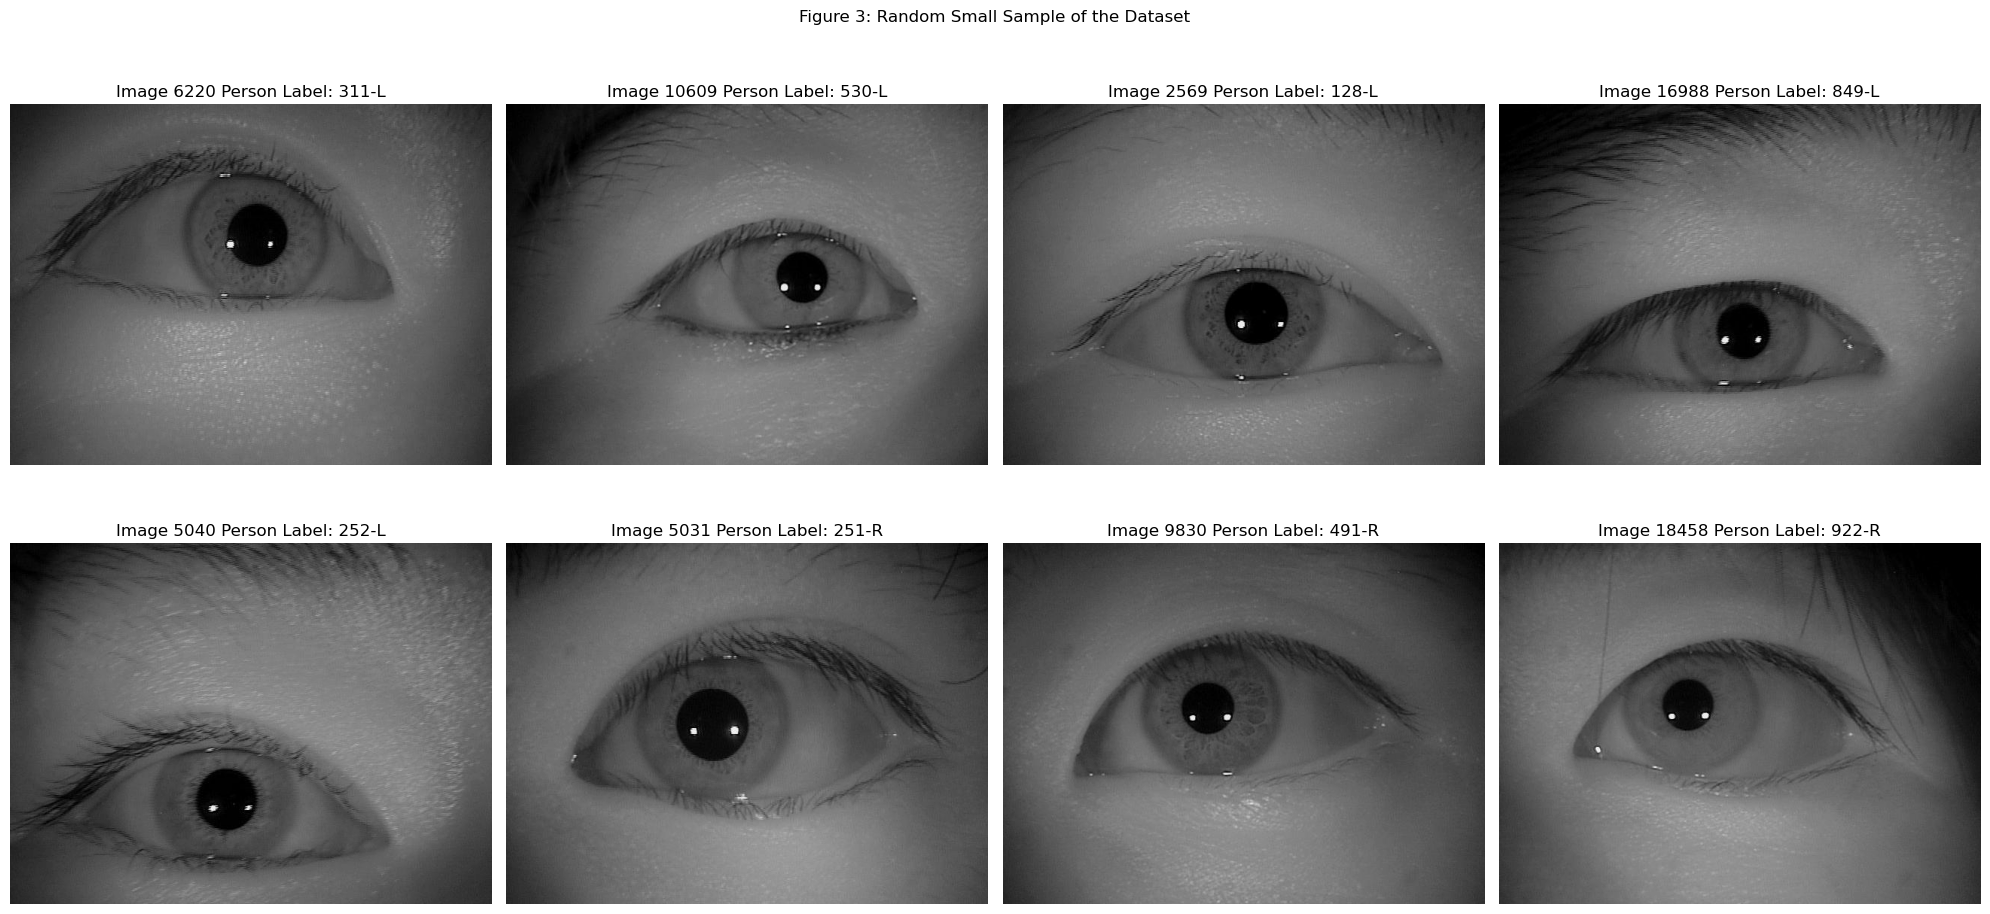

In [34]:
show_random_samples(df, 8)

The width of the images:  640
The height of the images:  480
Shape (640, 480)


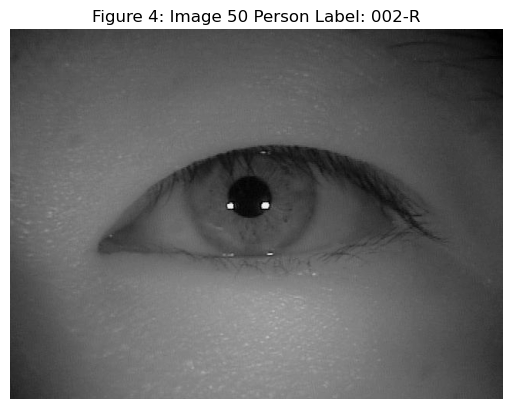

In [35]:
image_path = df.loc[50, "ImagePath"]
image = PIL.Image.open(image_path)
plt.imshow(image, cmap='gray')
plt.title(f"Figure 4: Image {50} Person Label: {df.loc[50, 'Label']}")
plt.axis("off")
width, height = image.size
print("The width of the images: ", width)
print("The height of the images: ", height)
print("Shape", image.size)

#### Calculate sizes and aspect ratios:


In [36]:
image_sizes = []
aspect_ratios = []

for image_path in df['ImagePath']:
    image = PIL.Image.open(image_path)
    width, height = image.size
    image_sizes.append(width * height)
    aspect_ratios.append(width / height)

#### Distribution of images sizes:


Text(0, 0.5, 'Frequency')

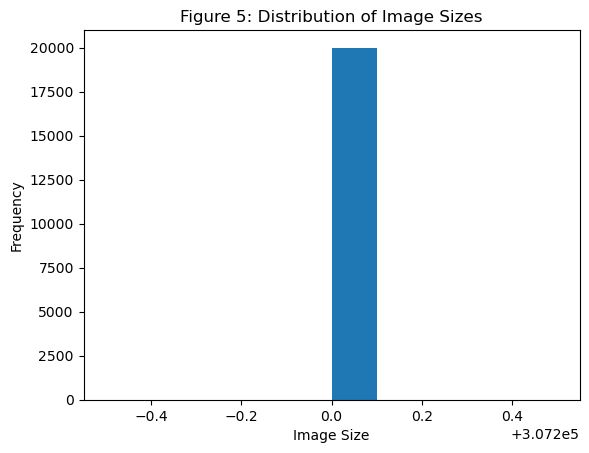

In [37]:
plt.hist(image_sizes, label="Image Size")
plt.title("Figure 5: Distribution of Image Sizes")
plt.xlabel("Image Size")
plt.ylabel("Frequency")

#### Distribution of aspect ratios


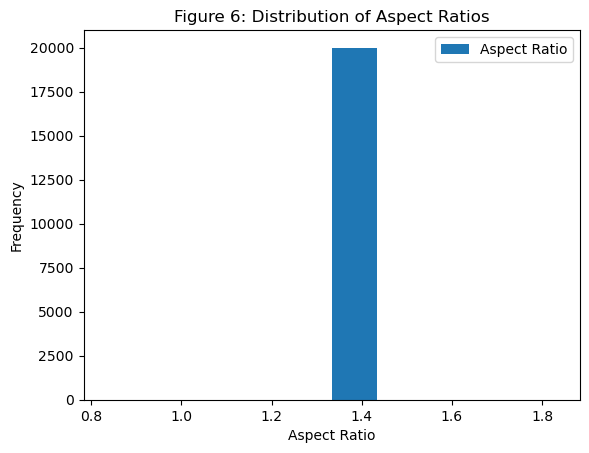

In [38]:
plt.hist(aspect_ratios, label="Aspect Ratio")
plt.title("Figure 6: Distribution of Aspect Ratios")
plt.xlabel("Aspect Ratio")
plt.ylabel("Frequency")
plt.legend()

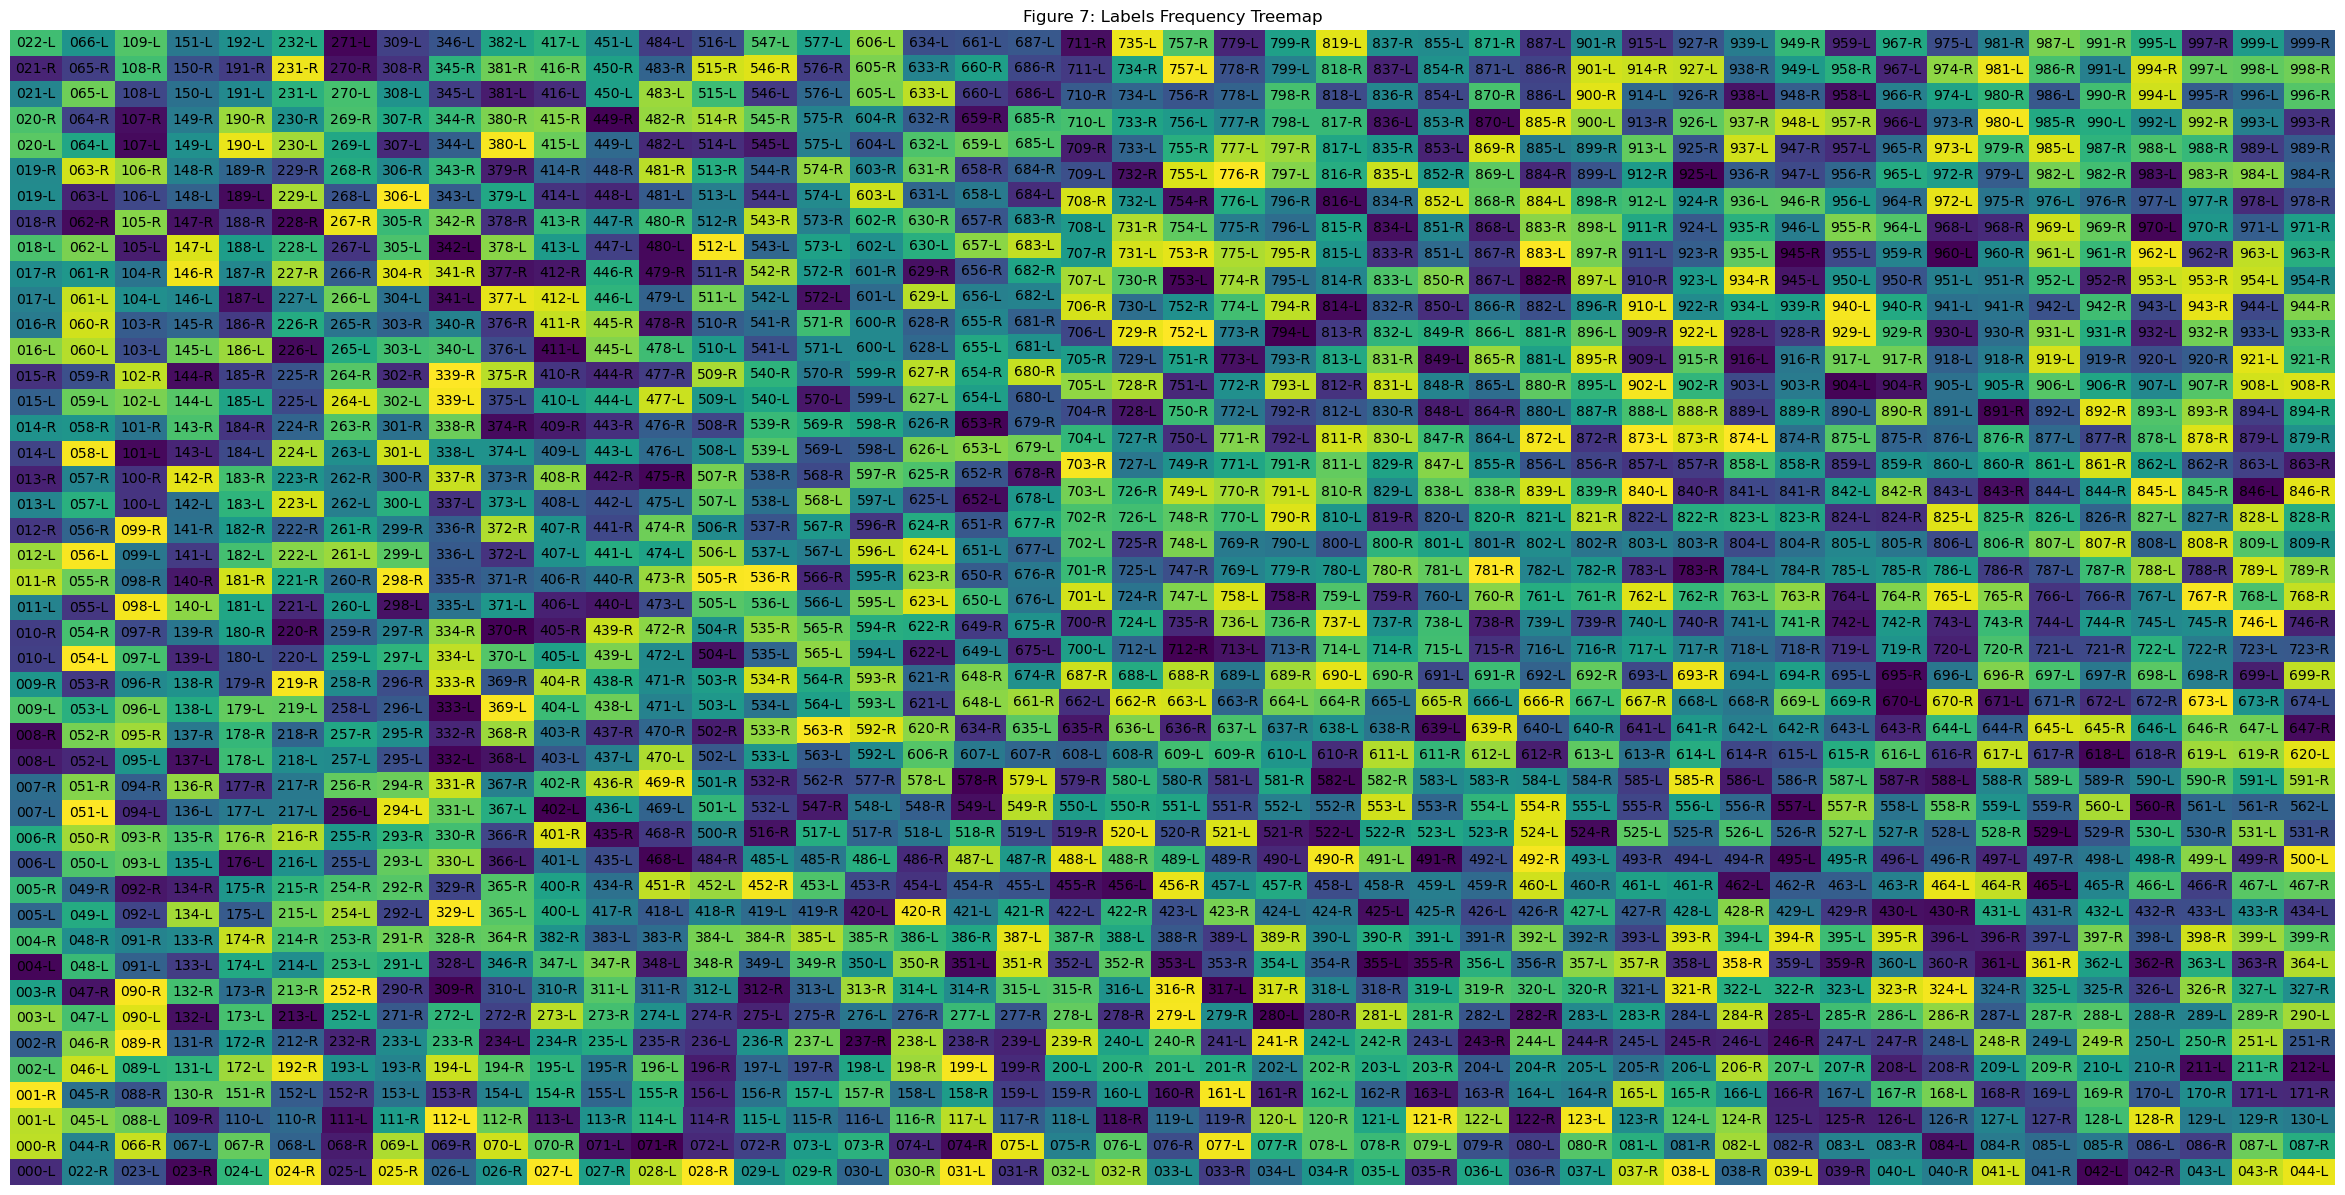

In [39]:
plt.figure(figsize=(30, 15))
squarify.plot(sizes=df['Label'].value_counts(), label=df['Label'].unique())
plt.axis('off')
plt.title('Figure 7: Labels Frequency Treemap')
plt.show()  # I have done it for the level distribution

#### Class Distribution Bar Chart


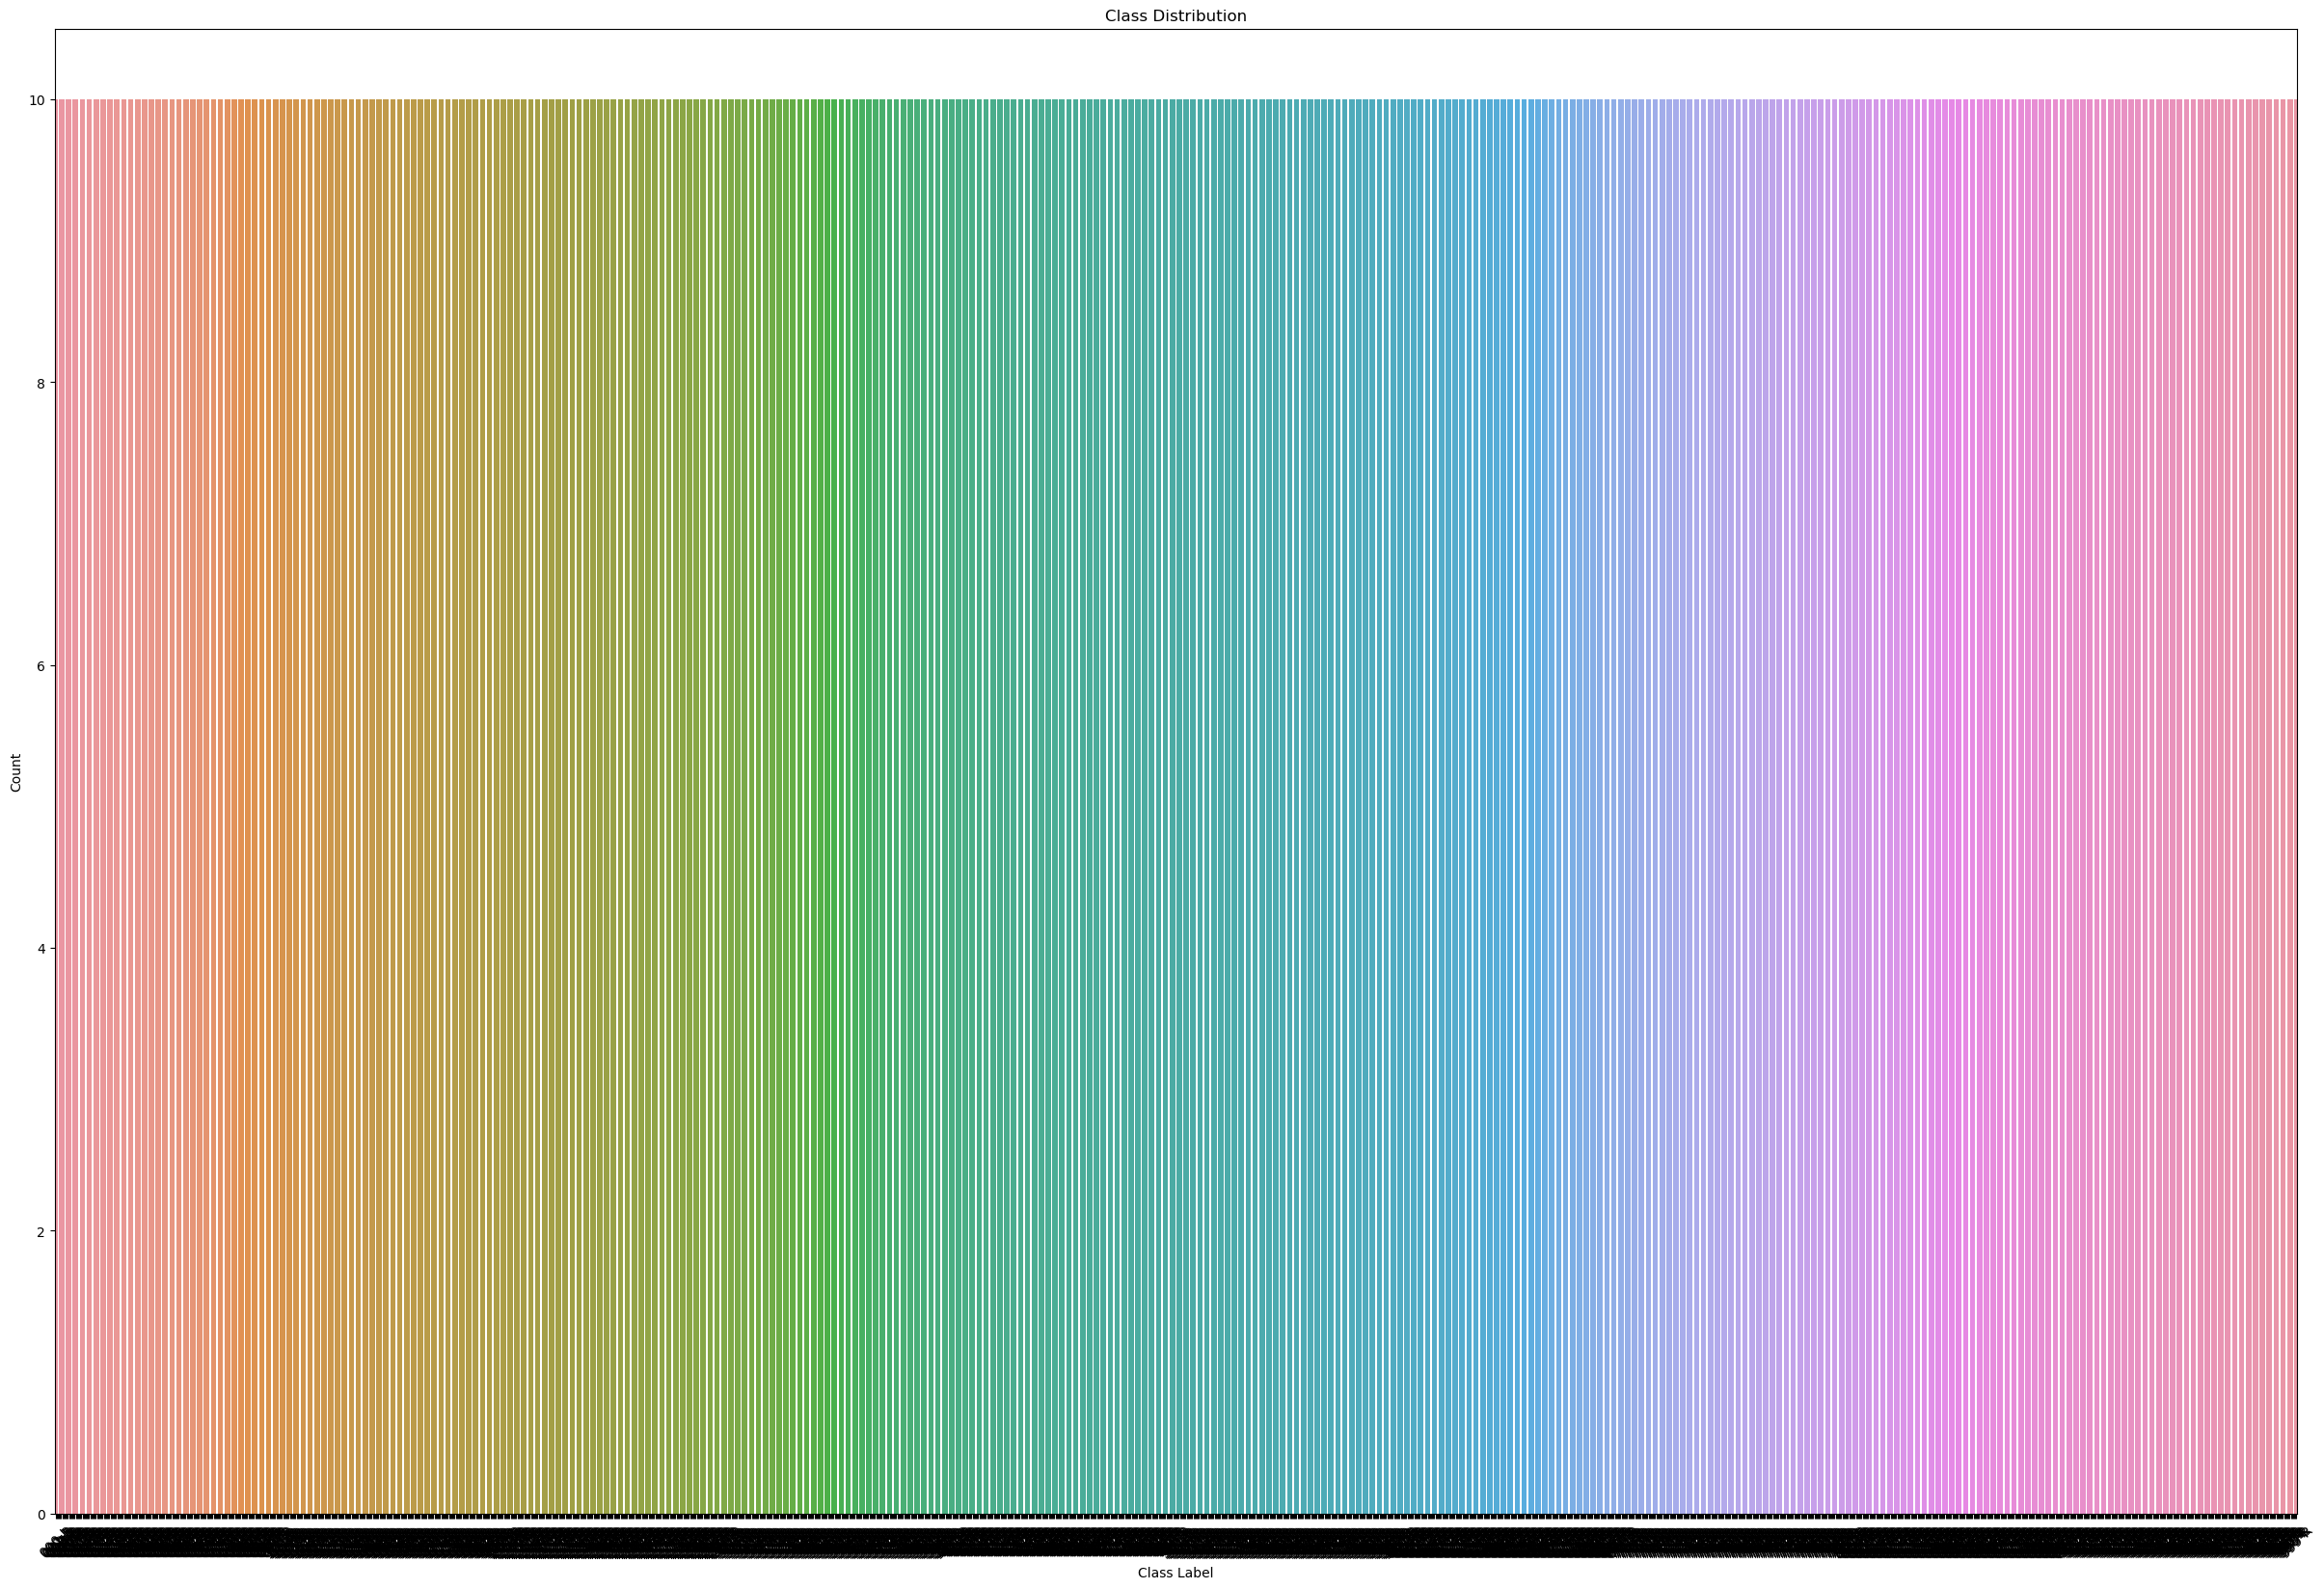

In [14]:
plt.figure(figsize=(30, 20))
sns.countplot(x='Label', data=df)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Color Distribution analysis


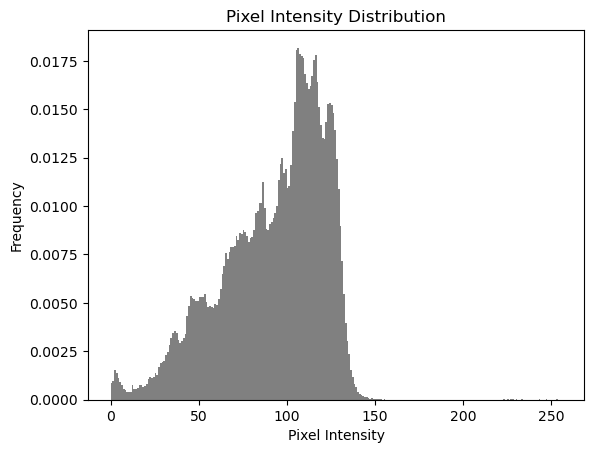

In [15]:
def plot_pixel_intensity(image):
    plt.hist(np.array(image).ravel(), bins=256,
             range=(0, 256), density=True, color='gray')
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()


# Example usage
image_path = df.loc[0, 'ImagePath']
image = PIL.Image.open(image_path).convert(
    'L')  # Convert to grayscale if needed
plot_pixel_intensity(image)

### Pairwise Image Comparisons


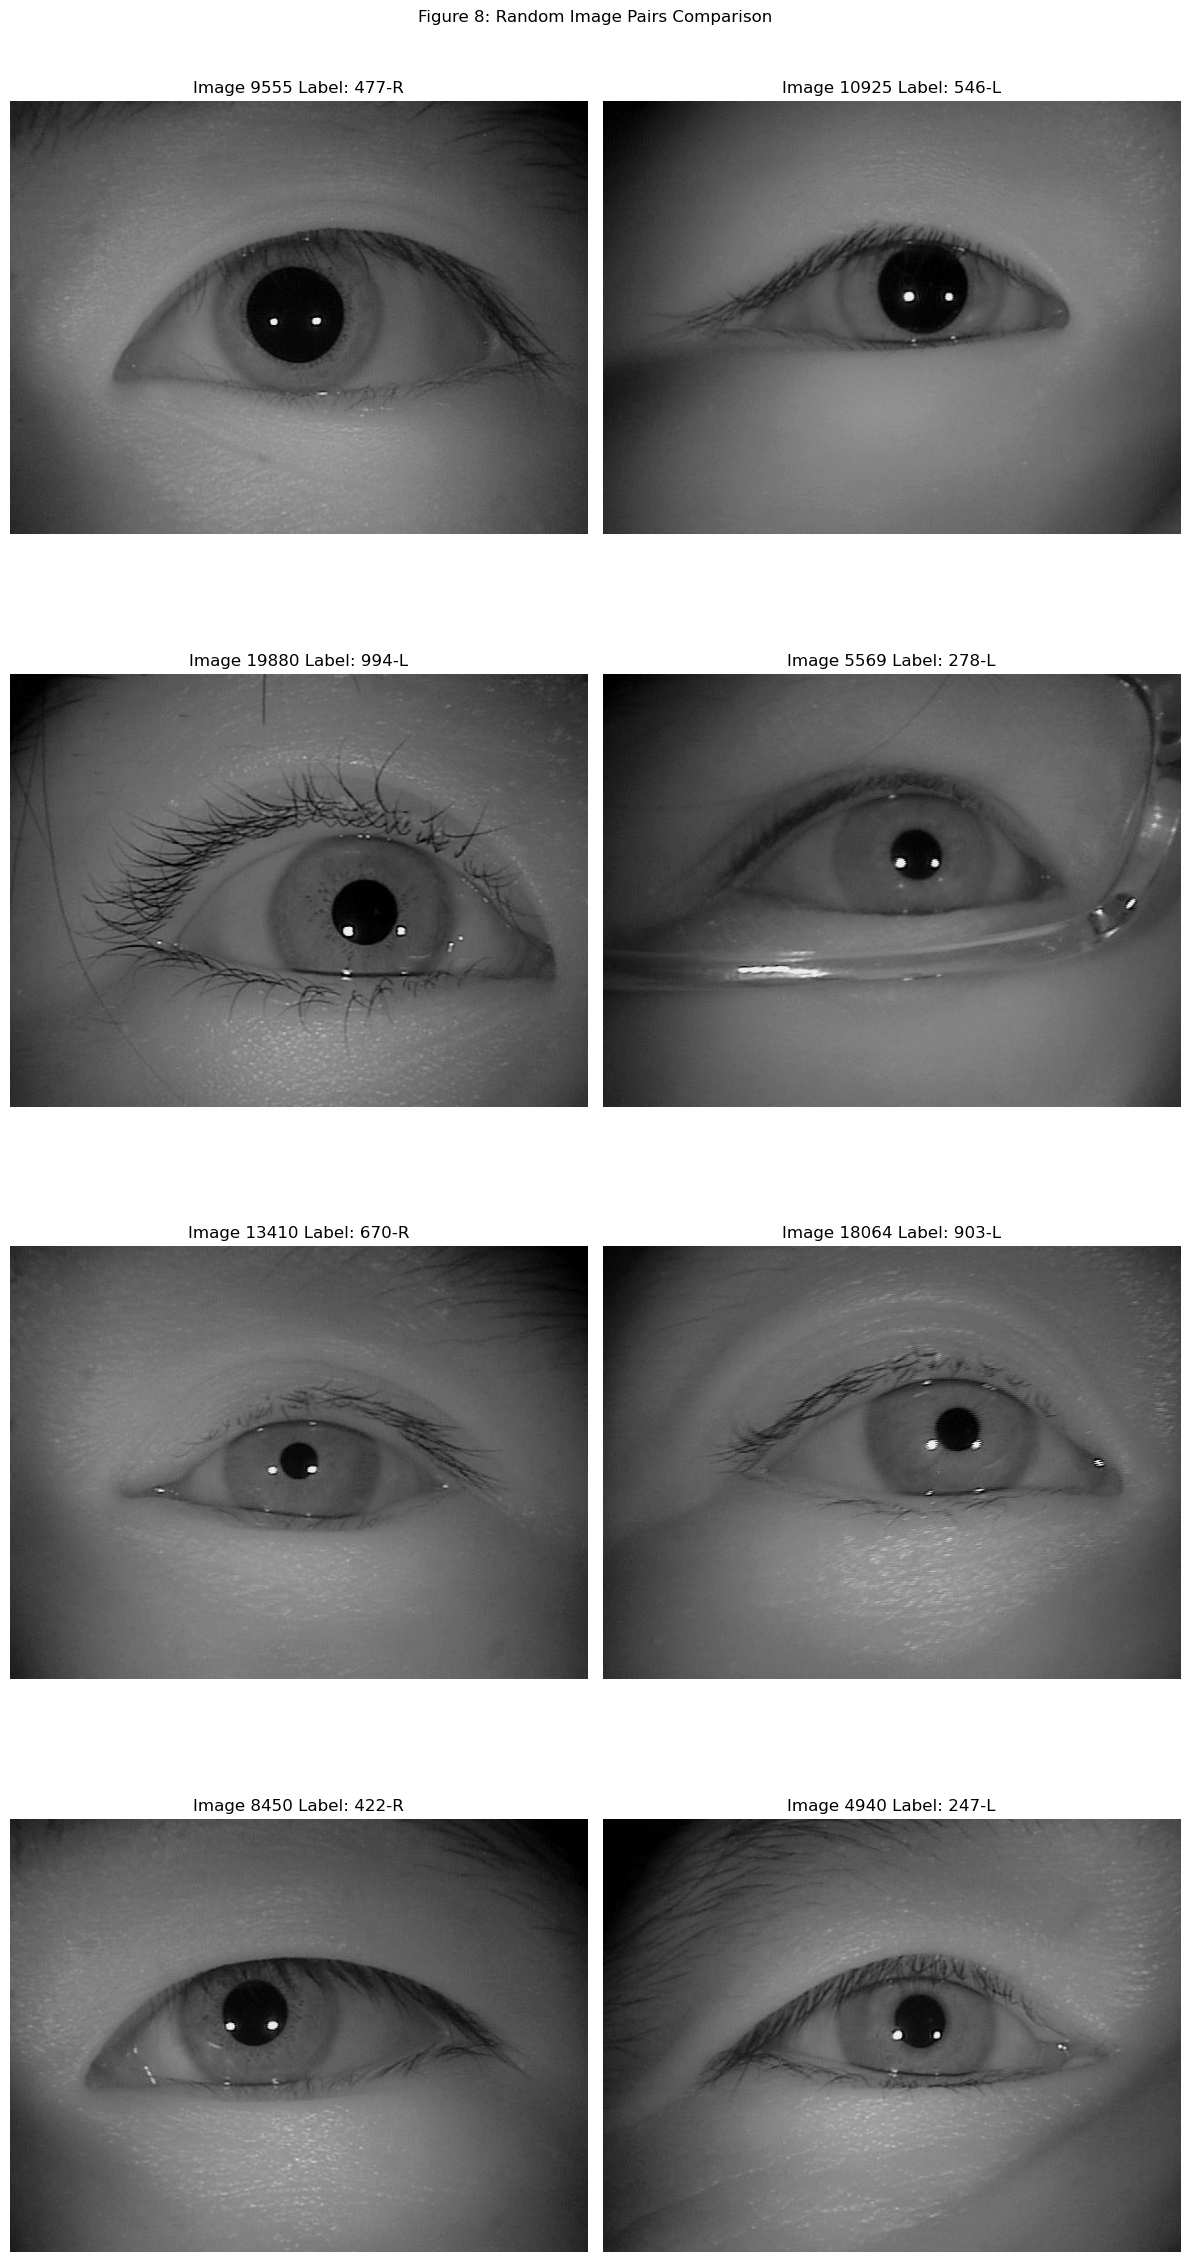

In [16]:
def plot_image_pairs(df, num_pairs):
    fig, axes = plt.subplots(num_pairs, 2, figsize=(12, num_pairs * 6))
    for i in range(num_pairs):
        idx1, idx2 = random.sample(range(df.shape[0]), 2)
        image_path1 = df.loc[idx1, 'ImagePath']
        image_path2 = df.loc[idx2, 'ImagePath']

        image1 = PIL.Image.open(image_path1).convert('L')
        image2 = PIL.Image.open(image_path2).convert('L')

        ax1 = axes[i, 0]
        ax1.imshow(image1, cmap='gray')
        ax1.set_title(f"Image {idx1} Label: {df.loc[idx1, 'Label']}")
        ax1.axis('off')

        ax2 = axes[i, 1]
        ax2.imshow(image2, cmap='gray')
        ax2.set_title(f"Image {idx2} Label: {df.loc[idx2, 'Label']}")
        ax2.axis('off')

    plt.suptitle('Figure 8: Random Image Pairs Comparison')
    plt.tight_layout()
    plt.show()


# Example usage
plot_image_pairs(df, 4)

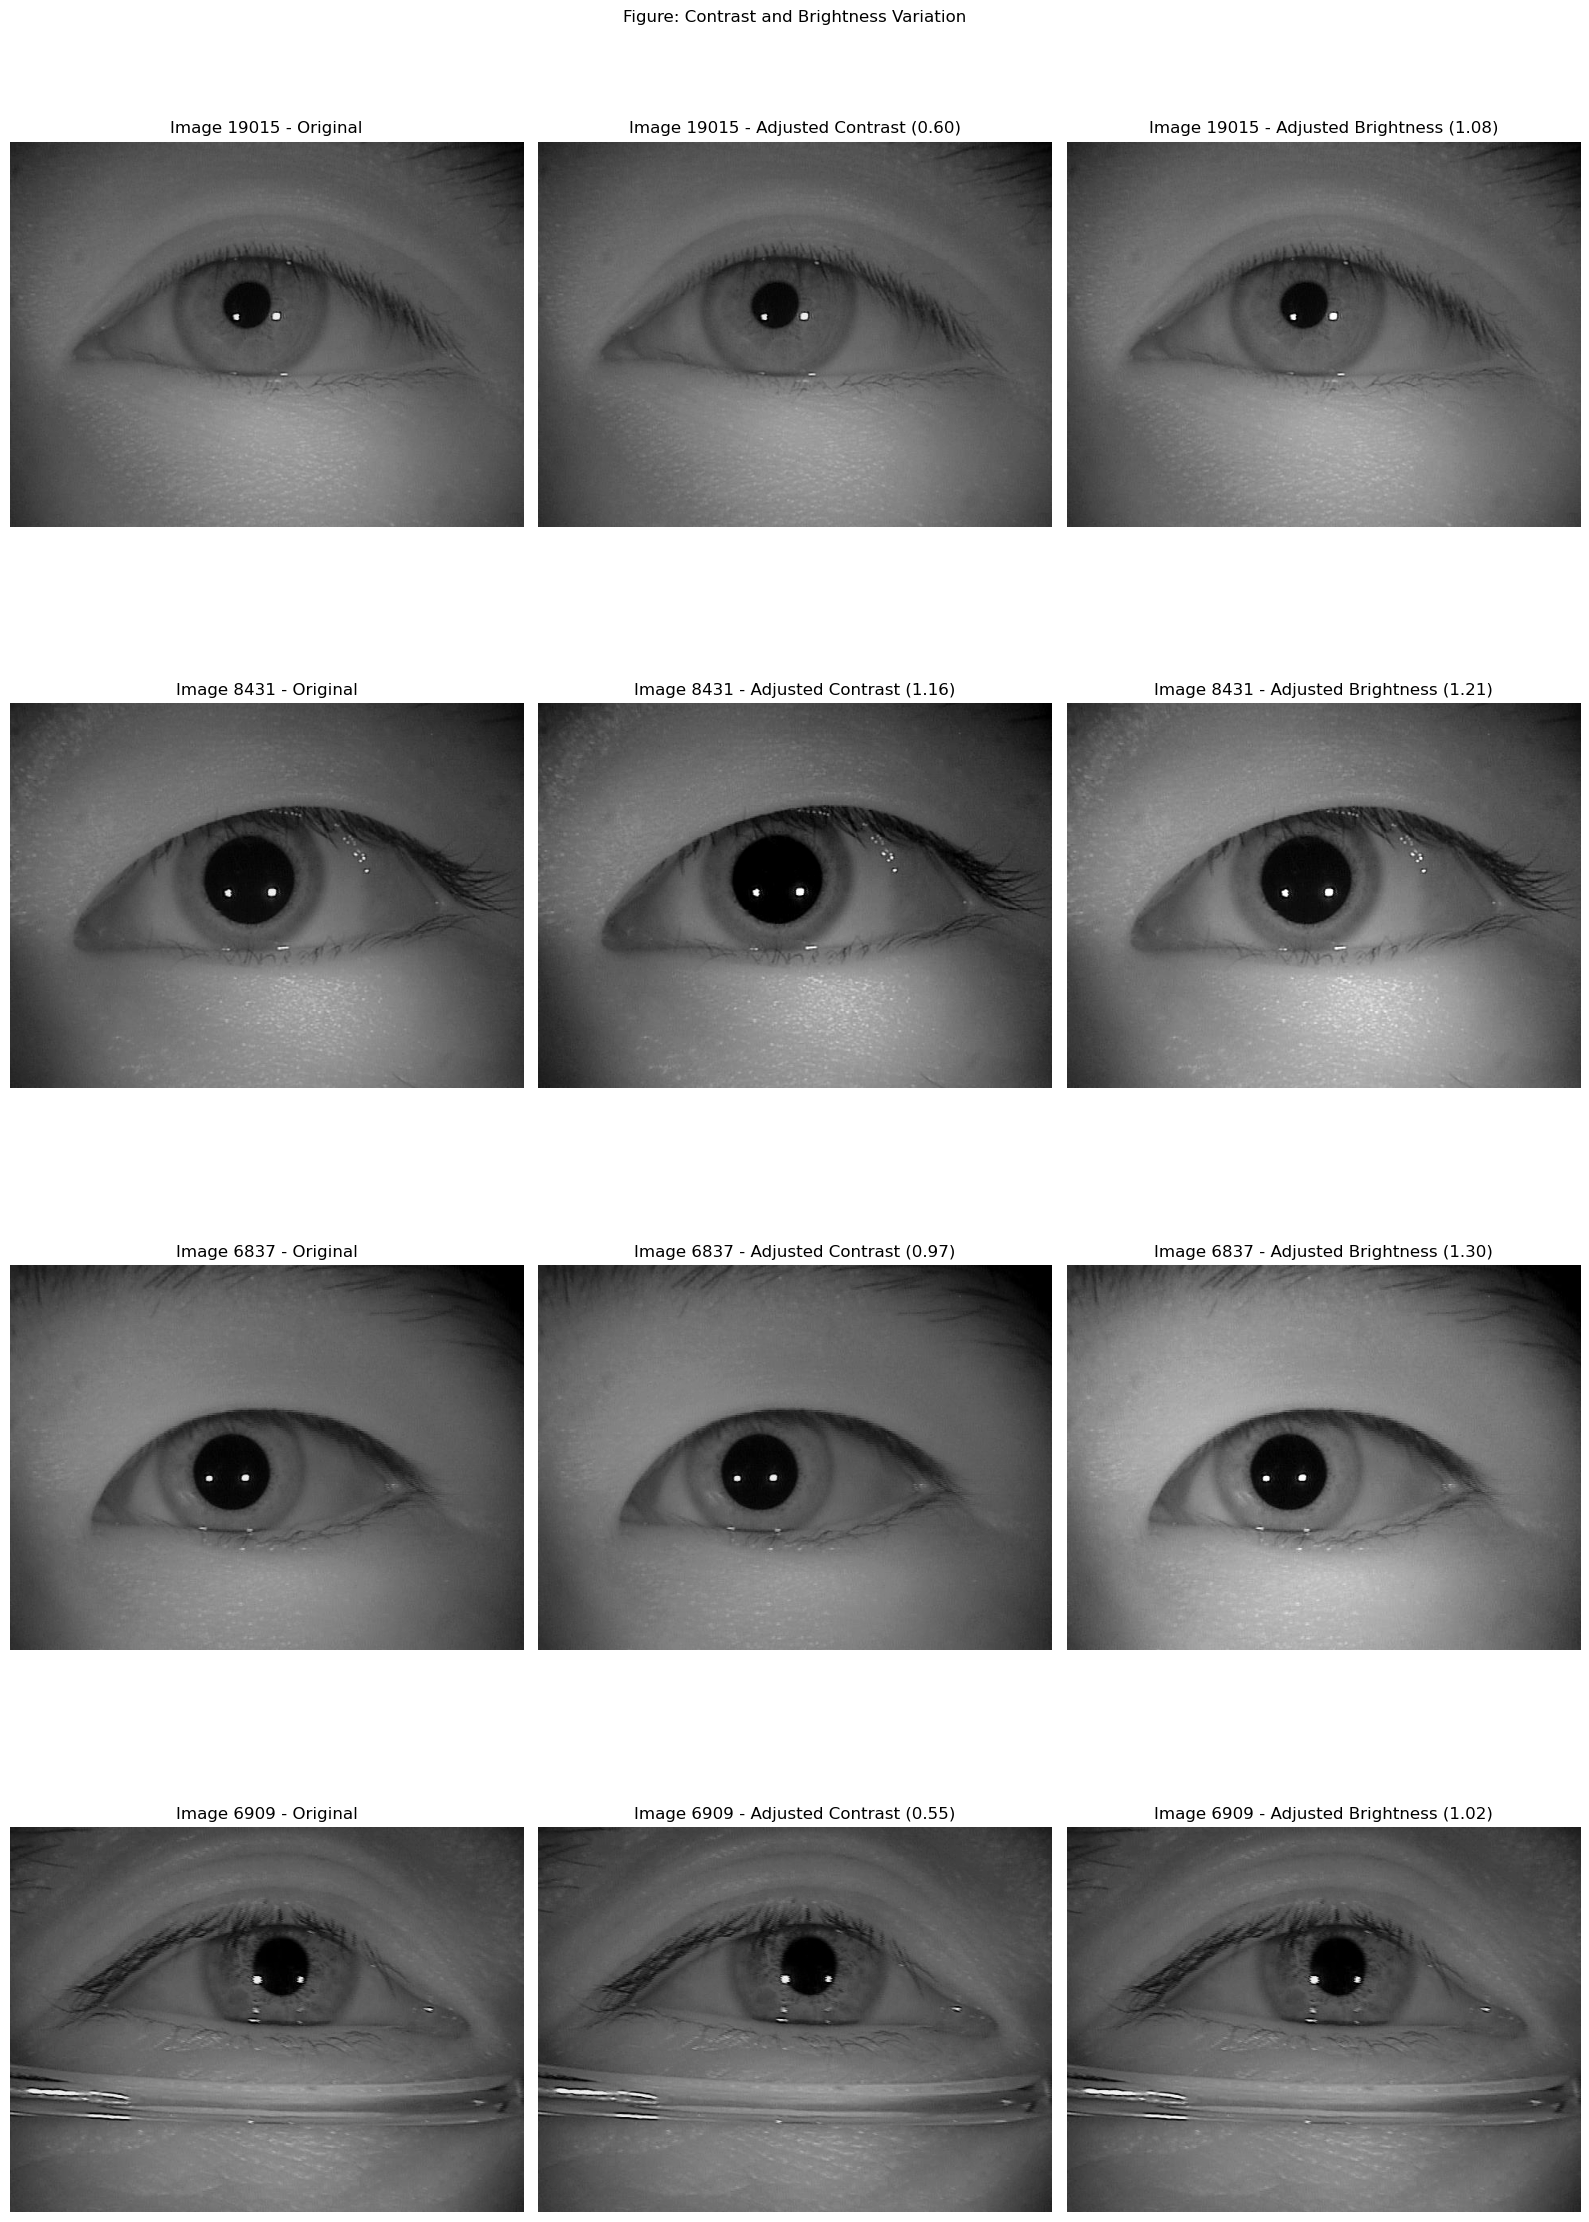

In [20]:
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import PIL.ImageEnhance


def visualize_contrast_brightness(df, num_samples=4):
    fig, axes = plt.subplots(num_samples, 3, figsize=(16, 6*num_samples))
    for i in range(num_samples):
        idx = random.randint(0, df.shape[0] - 1)
        image_path = df.loc[idx, "ImagePath"]
        image = PIL.Image.open(image_path).convert('L')  # Convert to grayscale

        # Original image
        ax1 = axes[i, 0]
        ax1.imshow(image, cmap='gray')
        ax1.set_title(f"Image {idx} - Original")
        ax1.axis("off")

        # Adjusted contrast
        contrast_factor = random.uniform(0.5, 1.5)
        enhancer = PIL.ImageEnhance.Contrast(image)
        adjusted_image = enhancer.enhance(contrast_factor)
        ax2 = axes[i, 1]
        ax2.imshow(adjusted_image, cmap='gray')
        ax2.set_title(
            f"Image {idx} - Adjusted Contrast ({contrast_factor:.2f})")
        ax2.axis("off")

        # Adjusted brightness
        brightness_factor = random.uniform(0.5, 1.5)
        enhancer = PIL.ImageEnhance.Brightness(image)
        adjusted_image = enhancer.enhance(brightness_factor)
        ax3 = axes[i, 2]
        ax3.imshow(adjusted_image, cmap='gray')
        ax3.set_title(
            f"Image {idx} - Adjusted Brightness ({brightness_factor:.2f})")
        ax3.axis("off")

    plt.suptitle('Figure: Contrast and Brightness Variation')
    plt.tight_layout()
    plt.show()


# Example usage
visualize_contrast_brightness(df)

### Preparing Dataset for Training


In [18]:
# Dataset Config
SIZE = 20000
# DUE TO THE RESOURCE LIMITATION I RESIZING THESE IMages
NUM_CLASSES = 2000
IMG_HEIGHT = 150
IMG_WIDTH = 150
NUM_CHANNELS = 1
input_shape = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

## Resizing is done with keeping the aspect rat


In [19]:
def resize_keep_aspect_ration(img, target_height=IMG_HEIGHT, target_width=IMG_WIDTH, pad_value=255):

    aspect_ratio = img.shape[1] / img.shape[0]

    # Get the new sizes with keeping the aspect ratio
    if aspect_ratio > target_width / target_height:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    resized_img = cv2.resize(img, (new_width, new_height))

    # Padding up and down so the image is in the middle
    preprocessed_img = np.full(
        (target_height, target_width), pad_value, dtype=np.uint8)
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2
    preprocessed_img[y_offset:y_offset + new_height,
                     x_offset:x_offset + new_width] = resized_img

    return preprocessed_img

-The image preprocessing function will include:

    - Read with greyscale.
    - Resizing with keeping the aspcet ratio.
    - Normalization. [0, 1]


In [20]:
def preprocess_image(img_dir):
    img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    img = resize_keep_aspect_ration(img)
    img = img/255.

    return img

###### This is an example of performing image resizing output:


<function matplotlib.pyplot.show(close=None, block=None)>

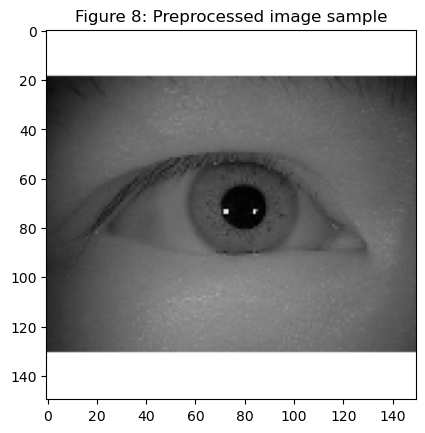

In [21]:
plt.imshow(preprocess_image(df.iloc[5]['ImagePath']), cmap="gray")
plt.title("Figure 8: Preprocessed image sample")
plt.show

- labels preparing:


In [42]:
def preprocess_labels(df):
    labels = df['Label'].astype(str)
    le = LabelEncoder()
    le.fit(labels)
    labels = le.transform(labels)
    return labels

### Split the dataset into trainig, testing and validation dataset. The splitting rule is 70:15:15


In [45]:
import numpy as np


def split_dataset(preprocessed_images, preprocessed_labels, train_size=0.7, validation_size=0.15, shuffle=True):
    np.random.seed(1190652)
    SIZE = len(preprocessed_images)
    indices = np.arange(SIZE)
    if shuffle:
        np.random.shuffle(indices)

    train_samples = int(SIZE * train_size)
    validation_samples = int(SIZE * validation_size)

    train_indices = indices[:train_samples]
    validation_indices = indices[train_samples:train_samples +
                                 validation_samples]
    test_indices = indices[train_samples + validation_samples:]

    x_train = preprocessed_images[train_indices]
    y_train = preprocessed_labels[train_indices]
    x_valid = preprocessed_images[validation_indices]
    y_valid = preprocessed_labels[validation_indices]
    x_test = preprocessed_images[test_indices]
    y_test = preprocessed_labels[test_indices]

    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [46]:
def prepare_dataset(df):
    preprocessed_images = []
    for i in range(SIZE):
        image = preprocess_image(images[i])
        preprocessed_images.append(image)

    preprocessed_images = np.array(
        preprocessed_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
    preprocessed_labels = preprocess_labels(df)
    return split_dataset(preprocessed_images, preprocessed_labels)

In [47]:
x_train, x_valid, x_test, y_train, y_valid, y_test = prepare_dataset(df)
print("Triaing set size: ", x_train.shape)
print("Validation set size: ", x_valid.shape)
print("Testing set size: ", x_test.shape)

Triaing set size:  (14000, 150, 150, 1)
Validation set size:  (3000, 150, 150, 1)
Testing set size:  (3000, 150, 150, 1)


In [48]:
print(input_shape)

(150, 150, 1)


Encoded Person Label is: 1484


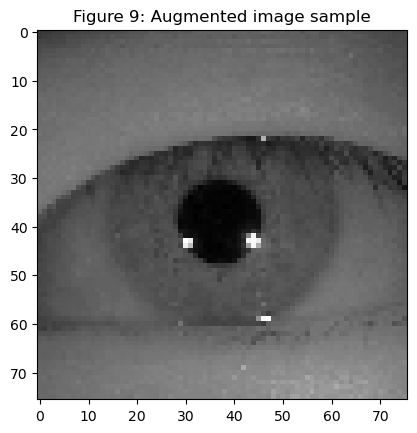

In [49]:
import tensorflow as tf
from tensorflow.keras.layers import Layer


class CentralCrop(Layer):
    def __init__(self, central_fraction=0.5):
        super(CentralCrop, self).__init__()
        self.central_fraction = central_fraction

    def call(self, inputs):
        return tf.image.central_crop(inputs, central_fraction=self.central_fraction)


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)),
    CentralCrop(central_fraction=0.5)
])

augmented_images = data_augmentation(x_train)
print(f'Encoded Person Label is: {y_valid[70]}')
plt.imshow(augmented_images[80], cmap="gray")
plt.title("Figure 9: Augmented image sample")
plt.show()

In [55]:
# Training Config:
EPOCHS = 100
BATCH_SIZE = 32
loss = 'sparse_categorical_crossentropy'
# optimizer = 'adam'
activation = "leaky_relu"
initial_learning_rate = 0.0010000000474974513
optimizer = Adam(learning_rate=initial_learning_rate)

earlyStopping = EarlyStopping(
    monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(
    '.mdl_wts.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

In [56]:
def create_model():
    """
    Create the model architicure and compile it, call on pre-set values.
    Returns:
        model (keras.Sequential): a model compiled with its layers
    """
    padding = 'same'
    poolpadding = 'valid'

    model = Sequential([
        Input(input_shape),
        # Features extraction

        Conv2D(32, (5, 5), padding=padding,
               activation=activation, name="Conv1"),
        BatchNormalization(axis=-1, name="BN1"),
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool1"),
        GaussianNoise(0.1, name="GaussianNoise"),
        Dropout(0.1, name="Dropout1"),

        Conv2D(64, (5, 5), padding=padding,
               activation=activation, name="Conv2"),
        BatchNormalization(axis=-1, name="BN2"),
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool2"),
        Dropout(0.1, name="Dropout2"),

        Conv2D(128, (5, 5), padding=padding,
               activation=activation, name="Conv3"),
        BatchNormalization(axis=-1, name="BN3"),
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool3"),
        Dropout(0.25, name="Dropout3"),

        Conv2D(256, (3, 3), padding=padding,
               activation=activation, name="Conv4"),
        BatchNormalization(axis=-1, name="BN4"),
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool4"),
        Dropout(0.25, name="Dropout4"),

        Conv2D(256, (3, 3), padding=padding,
               activation=activation, name="Conv5"),
        BatchNormalization(axis=-1, name="BN5"),
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool5"),
        Dropout(0.25, name="Dropout5"),

        Conv2D(512, (3, 3), padding=padding,
               activation=activation, name="Conv6"),
        BatchNormalization(axis=-1, name="BN6"),
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool6"),
        Dropout(0.45, name="Dropout6"),

        Conv2D(512, (2, 2), padding=padding,
               activation=activation, name="Conv7"),
        BatchNormalization(axis=-1, name="BN7"),
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool7"),
        Dropout(0.5, name="Dropout7"),

        # Flatten and fully connected layers, classifier using relu sofftmax
        Flatten(),
        Dense(128, activation=activation, name="Dense1"),
        Dense(2000, activation='softmax', name="SoftmaxClasses"),
    ],
        name="IRISRecognizer")
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [58]:
model = create_model()
model.summary()

Model: "IRISRecognizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 150, 150, 32)      832       
                                                                 
 BN1 (BatchNormalization)    (None, 150, 150, 32)      128       
                                                                 
 Mpool1 (MaxPooling2D)       (None, 75, 75, 32)        0         
                                                                 
 GaussianNoise (GaussianNoi  (None, 75, 75, 32)        0         
 se)                                                             
                                                                 
 Dropout1 (Dropout)          (None, 75, 75, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 75, 75, 64)        51264     
                                                    

In [ ]:
history = model.fit(np.array(x_train), y_train, validation_data=(np.array(x_valid), y_valid),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/100
  2/500 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.0000e+00 - loss: 7.9566   

I0000 00:00:1719618380.023761      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719618380.050647      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 50ms/step - accuracy: 0.0011 - loss: 7.6407 - val_accuracy: 0.0015 - val_loss: 8.6547 - learning_rate: 0.0010
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.0167 - loss: 6.3372 - val_accuracy: 0.0245 - val_loss: 6.1919 - learning_rate: 0.0010
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.0505 - loss: 5.3321 - val_accuracy: 0.0640 - val_loss: 5.4214 - learning_rate: 0.0010
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.1192 - loss: 4.4237 - val_accuracy: 0.1650 - val_loss: 4.4673 - learning_rate: 0.0010
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.2438 - loss: 3.5111 - val_accuracy: 0.1865 - val_loss: 4.2010 - learning_rate: 0.0010
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.3663 - loss: 2.7247 - val_accuracy: 0.3955 - val_loss: 2.8119 - learning_rate: 0.0010
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4701 - loss: 

### Graph between Model Performance (Loss and Accuracy) and Number of Epochs


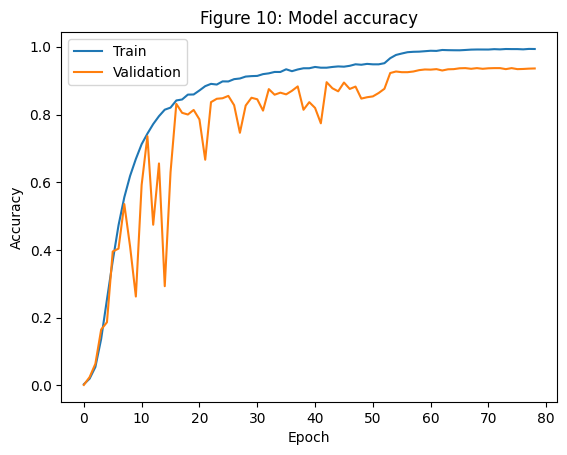

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Figure 10: Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

### Saving the model


In [ ]:
model.save(".../models/IRISRecognizer.h5")
reconstructed_model = keras.models.load_model("../models/IRISRecognizer.h5")
test_loss, test_acc = reconstructed_model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc*100:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9238 - loss: 0.6910
Test accuracy: 92.500
